<a href="https://colab.research.google.com/github/jmlDC/MediaBias-Thesis22-23/blob/Trying-Straight-Methods/ScrapingNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MEDIA BIAS Thesis

# Setting up Environment

### PIP install

In [ ]:
!pip3 install requests-html
!apt update
!apt install chromium-chromedriver
!pip3 install selenium
!pip3 install webdriver-manager

In [ ]:
# Needed for Selenium
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


### Imports

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [ ]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

from requests_html import HTMLSession 

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By


### Mounting to GDrive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### dir variable

In [3]:
dir  = "/content/gdrive/MyDrive/THESIS-MS/Truth-Thesis22-23/"

# Scraping

## Politifact

In [ ]:
## Politifact 
pagesToGet= 1
upperframe=[]  
site = "politifact"


for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.politifact.com/factchecks/list/?page='+str(page)
    print(url)
    
    #an exception might be thrown, so the code should be in a try-except block
    try:
        #use the browser to get the url. This is suspicious command that might blow up.
        page=requests.get(url)                             # this might throw an exception if something goes wrong.
    
    except Exception as e:                                   # this describes what to do if an exception is thrown
        error_type, error_obj, error_info = sys.exc_info()      # get the exception information
        print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
        print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
        continue                                              #ignore this page. Abandon this and go back.

    time.sleep(2)   
    soup=BeautifulSoup(page.text,'html.parser')
    frame=[]
    links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    print(len(links))

    
    filename= f"{dir + site}NEWS.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Statement,Link,Date, Source, Label\n"
    f.write(headers)
    
    for j in links:
        Statement = j.find("div",attrs={'class':'m-statement__quote'}).text.strip()
        Link = "https://www.politifact.com"
        Link += j.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip()
        Date = j.find('div',attrs={'class':'m-statement__body'}).find('footer').text[-14:-1].strip()
        Source = j.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
        Label = j.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
        frame.append((Statement,Link,Date,Source,Label))
        f.write(Statement.replace(",","^")+","+Link+","+Date.replace(",","^")+","+Source.replace(",","^")+","+Label.replace(",","^")+"\n")
    upperframe.extend(frame)
f.close()
data=pd.DataFrame(upperframe, columns=['Statement','Link','Date','Source','Label'])
data.head()

processing page : 1
https://www.politifact.com/factchecks/list/?page=1
30


,Statement,Link,Date,Source,Label
0,"Under Kathy Hoffman, “student test scores plum...",https://www.politifact.com/factchecks/2022/sep...,"mber 19, 2022",Tom Horne,barely-true
1,Image shows a Rebekah Jones campaign event.,https://www.politifact.com/factchecks/2022/sep...,"mber 19, 2022",Matt Gaetz,barely-true
2,"Then-Vice President Mike Pence ""seized power"" ...",https://www.politifact.com/factchecks/2022/sep...,"mber 19, 2022",Mark Finchem,pants-fire
3,“The Simpsons” predicted Queen Elizabeth II’s ...,https://www.politifact.com/factchecks/2022/sep...,"mber 19, 2022",Viral image,pants-fire
4,"“Since 2019, I've successfully lobbied for the...",https://www.politifact.com/factchecks/2022/sep...,"mber 19, 2022",Kathy Hoffman,true


## Extract Source Function

In [ ]:
def extract_source(url):
    agent = {"User-Agent":"Chrome/105.0.0.0"}
    try:
      source=requests.get(url, headers=agent)
    except Exception as e:                                   # this describes what to do if an exception is thrown
      error_type, error_obj, error_info = sys.exc_info()      # get the exception information
      print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
      print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
    
    return source                                               #ignore this page. Abandon this and go back.

## Manila Bulletin

In [ ]:
## Manila bulletin
pagesToGet= 1
upperframe=[]  
topic = "ukraine war"
site = "manilaBulletin"

data=pd.DataFrame(columns=['Statement','Link','Date',"Topic"])


for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://mb.com.ph/page/'+str(page)+'/?s='+topic.replace(" ", "+")
    print(url)

    time.sleep(2)   
    soup=BeautifulSoup(extract_source(url).text, 'html.parser')

    links=soup.find("article", {'class' : 'content-bar col-12 col-lg-12 order-1 col-xl order-xl-2'}).find_all('li',attrs={'class':'article'})
    print(len(links))
    
    filename= f"{dir}{site}-{topic}-NEWS-List.csv"    
    for j in links:
        frame=[]
        try:
          Statement = j.find('h4').find('a').text
          Link = j.find('h4',attrs={'class':'title'}).find('a')['href'].strip()
          Date = j.find('time', {'class': 'time-ago'})['data-time'][0:10].strip()
          frame.extend((Statement, Link, Date, topic))
        except Exception as e:
            pass

        data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)
data.to_csv(filename)
data.head()

processing page : 1
https://mb.com.ph/page/1/?s=ukraine+war
16


,Statement,Link,Date,Topic
0,Pope urges end to ‘senseless’ Ukraine war duri...,https://mb.com.ph/2022/09/14/pope-urges-end-to...,2022-09-14,ukraine war
1,Gatchalian seeks impact assessment of Russia-U...,https://mb.com.ph/2022/08/04/gatchalian-seeks-...,2022-08-04,ukraine war
2,"US sanctions Putin ‘girlfriend,’ more oligarch...",https://mb.com.ph/2022/08/03/us-sanctions-puti...,2022-08-03,ukraine war
3,Pacquiao-Yoo exhibition match to serve as char...,https://mb.com.ph/2022/07/20/pacquiao-yoo-exhi...,2022-07-20,ukraine war
4,Ukraine war to dominate G20 finance chief meet...,https://mb.com.ph/2022/07/15/ukraine-war-to-do...,2022-07-15,ukraine war


In [ ]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site+'-'+topic}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  print(url)

  time.sleep(1)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')

  head=soup.find("article", {'id' : 'the-article-content'})
  # print(content.prettify())
  textList =soup.find("article", {'id' : 'the-article-content'}).find("section", {'class': 'article-content'}).find_all("p")
  
  
  row=[]
  try:
    Title = head.find('h2',{'class':'title'}).text.strip()
    Author = head.find('p',attrs={'class':'author'}).find('a').text[3:].strip()
    Date = head.find('p', attrs={'class': 'published'}).text[10:-9].strip(",") 
  except Exception as e:
      pass
  
  body = ""
  for t in textList:
    body += (t.text.replace('\u200b', '')) +"\n" 

  row.extend((Title, Author, Date, body))
  

  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

https://mb.com.ph/2022/09/14/pope-urges-end-to-senseless-ukraine-war-during-kazakhstan-visit/
https://mb.com.ph/2022/08/04/gatchalian-seeks-impact-assessment-of-russia-ukraine-war-on-ph/
https://mb.com.ph/2022/08/03/us-sanctions-putin-girlfriend-more-oligarchs-for-complicity-in-ukraine-war/
https://mb.com.ph/2022/07/20/pacquiao-yoo-exhibition-match-to-serve-as-charity-event-for-ukraine-war-victims/
https://mb.com.ph/2022/07/15/ukraine-war-to-dominate-g20-finance-chief-meeting-in-indonesia/
https://mb.com.ph/2022/06/27/ukraine-war-could-boost-illegal-drug-production-un/
https://mb.com.ph/2022/06/09/un-chief-warns-impact-of-ukraine-war-on-world-is-worsening/
https://mb.com.ph/2022/06/07/church-leader-calls-for-prayers-for-an-end-to-the-russia-ukraine-war/
https://mb.com.ph/2022/05/30/ph-reiterates-call-to-end-russia-ukraine-war-in-asean-russia-forum/
https://mb.com.ph/2022/05/23/ukraine-war-pandemic-push-colour-who-international-meet/
https://mb.com.ph/2022/05/10/putin-says-russia-defend

,Title,Author,Date,Text
0,Pope urges end to ‘senseless’ Ukraine war duri...,Agence-France-Presse,"September 14, 2022","NUR SULTAN, Kazakhstan – Pope Francis on Tuesd..."
1,Gatchalian seeks impact assessment of Russia-U...,Joseph Pedrajas,"August 4, 2022",Senator Sherwin Gatchalian wants an assessment...
2,"US sanctions Putin ‘girlfriend,’ more oligarch...",Agence-France-Presse,"August 3, 2022","WASHINGTON, United States – The United States ..."
3,Pacquiao-Yoo exhibition match to serve as char...,Carlo Anolin,"July 20, 2022",The showdown between Manny Pacquiao and DK Yoo...
4,Ukraine war to dominate G20 finance chief meet...,Agence-France-Presse,"July 15, 2022","BALI, Indonesia – Group of 20 finance minister..."


## ABS CBN

In [ ]:
## ABS CBN
pagesToGet= 2
topic = "Queen Elizabeth Death"
site = "ABS-CBN_NEWS"


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
userAgent = "Chrome/105.0.0.0"
chrome_options.add_argument(f"user-agent={userAgent}")
driver = webdriver.Chrome('chromedriver',options=chrome_options)

data=pd.DataFrame(columns=['Title','Link','Date',"Topic"])

for page in range(1,pagesToGet+1):
  url = 'https://news.abs-cbn.com/special-pages/search?q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)+'#gsc.tab=0&gsc.q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)
  print(url)

  driver.get(url)
  # WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.ID, '___gcse_0'))) 
  source = driver.page_source

  time.sleep(2)   
  soup = BeautifulSoup(source, 'html.parser')
  searches = soup.find_all('div', {'class':'gsc-webResult gsc-result'})
  filename= f"{dir}{site}-{topic}-NEWS-List.csv"     

  for x in searches:
    frame=[]
    Title = x.find('div', class_="gs-title").find("a").text.strip()
    Date = x.find('div', class_="gs-bidi-start-align gs-snippet").text[:12].strip()
    Link = x.find('a', class_="gs-title")['href']
    frame.extend((Title, Link, Date, topic))

    data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)



data.to_csv(filename)
driver.quit()
data





https://news.abs-cbn.com/special-pages/search?q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=1#gsc.tab=0&gsc.q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=1
https://news.abs-cbn.com/special-pages/search?q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=2#gsc.tab=0&gsc.q=Queen%20Elizabeth%20Death&gsc.sort=&gsc.page=2


,Title,Link,Date,Topic
0,Queen Elizabeth II begins solemn final journey...,https://news.abs-cbn.com/overseas/09/11/22/que...,"Sep 11, 2022",Queen Elizabeth Death
1,Queen Elizabeth II dies at 96 | ABS-CBN News,https://news.abs-cbn.com/overseas/09/09/22/que...,"Sep 9, 2022",Queen Elizabeth Death
2,London Bridge: The protocol after Queen Elizab...,https://news.abs-cbn.com/overseas/09/09/22/lon...,"Sep 9, 2022",Queen Elizabeth Death
3,The death of Queen Elizabeth II: Thursday's ti...,https://news.abs-cbn.com/overseas/09/09/22/the...,"Sep 9, 2022",Queen Elizabeth Death
4,Netflix suspends 'The Crown' filming after que...,https://news.abs-cbn.com/entertainment/09/10/2...,"Sep 10, 2022",Queen Elizabeth Death
5,Death of Queen Elizabeth II: What happens next...,https://news.abs-cbn.com/spotlight/09/15/22/de...,5 days ago .,Queen Elizabeth Death
6,Queen Elizabeth II: Record-breaking monarch | ...,https://news.abs-cbn.com/spotlight/09/09/22/qu...,"Sep 9, 2022",Queen Elizabeth Death
7,Operation Unicorn: The plan for Queen's death ...,https://news.abs-cbn.com/overseas/09/09/22/ope...,"Sep 9, 2022",Queen Elizabeth Death
8,Prince Philip's death has left 'huge void' for...,https://news.abs-cbn.com/overseas/04/11/21/pri...,"Apr 11, 2021",Queen Elizabeth Death
9,Sporting world pays tribute to Queen Elizabeth...,https://news.abs-cbn.com/sports/09/09/22/sport...,"Sep 9, 2022",Queen Elizabeth Death


In [ ]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site+'-'+topic}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  if ('multimedia/photo' in url):
    pass
  else:
    print(url)

    time.sleep(1)   
    soup=BeautifulSoup(extract_source(url).text, 'html.parser')
      
    row=[]
    
    Title = soup.find('h1',{'class':'news-title'}).text.strip()
    Author = soup.find('span',attrs={'class':'editor'}).text.strip()
    Date = soup.find('span', attrs={'class': 'date-posted'}).text[:-8].strip() 
    
    textList =soup.find("div", {'class' :'article-content'}).find_all("p")
    body = ""
    for t in textList:
      if (t.text != "RELATED VIDEO:"):
        body += (t.text) +"\n" 

    row.extend((Title, Author, Date, body))
    

    data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

https://news.abs-cbn.com/overseas/09/11/22/queen-elizabeth-ii-begins-solemn-final-journey
https://news.abs-cbn.com/overseas/09/09/22/queen-elizabeth-ii-dies-at-96
https://news.abs-cbn.com/overseas/09/09/22/london-bridge-the-protocol-after-queen-elizabeths-death
https://news.abs-cbn.com/overseas/09/09/22/the-death-of-queen-elizabeth-ii-thursdays-timeline
https://news.abs-cbn.com/entertainment/09/10/22/netflix-suspends-the-crown-filming-after-queens-death
https://news.abs-cbn.com/spotlight/09/15/22/death-of-queen-elizabeth-ii-what-happens-next
https://news.abs-cbn.com/spotlight/09/09/22/queen-elizabeth-ii-record-breaking-monarch
https://news.abs-cbn.com/overseas/09/09/22/operation-unicorn-the-plan-for-queens-death-in-scotland
https://news.abs-cbn.com/overseas/04/11/21/prince-philips-death-has-left-huge-void-for-queen-elizabeth-ii-says-son-andrew
https://news.abs-cbn.com/sports/09/09/22/sporting-world-pays-tribute-to-queen-elizabeth-ii


,Title,Author,Date,Text
0,Queen Elizabeth II begins solemn final journey...,"Callum Paton and Danny Kemp, Agence France-Presse",Sep 11 2022,LONDON (UPDATE) — Queen Elizabeth II embarks o...
1,"Queen Elizabeth II dies, Charles III succeeds","Stuart Graham with Phil Hazlewood in London, A...",Sep 09 2022,"Queen Elizabeth II, the longest-serving monarc..."
2,Operation London Bridge: What happens after th...,Deutsche Welle,Sep 09 2022,"The day has come, setting into motion a minute..."
3,The death of Queen Elizabeth II: Thursday's ti...,"Helen Rowe, Agence France-Presse",Sep 09 2022,LONDON (UPDATE) - A rare palace announcement a...
4,Netflix suspends 'The Crown' filming after dea...,Agence France-Presse,Sep 10 2022,Netflix suspended filming of its British royal...


## GMA 

In [ ]:
# https://www.gmanetwork.com/news/#/search;query=queen%20elizabeth%20death;sortBy=_score;isDesc=1

topic = "Queen Elizabeth Death"
site = "GMA-Network"


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-blink-features=AutomationControlled')
userAgent = "Chrome/105.0.0.0"
chrome_options.add_argument(f"user-agent={userAgent}")
driver = webdriver.Chrome('chromedriver',options=chrome_options)

data=pd.DataFrame(columns=['Title','Link','Date',"Topic"])

url = 'https://www.gmanetwork.com/news/#/search;query='+topic.replace(" ", "%20")+';sortBy=_score;isDesc=1'
print(url)

driver.get(url)
WebDriverWait(driver, 50).until(EC.visibility_of_element_located((By.CLASS_NAME, 'clearfix'))) 
source = driver.page_source

time.sleep(2)   
soup = BeautifulSoup(source, 'html.parser')
searches = soup.find_all('div', {'class':'zd-row-text-wrap'})
filename= f"{dir}{site}-{topic}-NEWS-List.csv"     
print(len(searches))

for x in searches:
  frame=[]
  Title = x.find('h4', class_="zd-result-title ng-star-inserted").text.strip()
  Date = x.find('div', class_="zd-result-subTitle ng-star-inserted").text[:-18].strip()
  partialTitle = ' '.join(Title.split()[:8])

  try:
    Link = ""
    to_Click = driver.find_element(By.XPATH, f"//*[contains(text(), '{Title}')]")
    print(to_Click.text)
    to_Click.click()
    driver.switch_to.window(driver.window_handles[1])
    Link = driver.current_url
    driver.close()
    driver.switch_to.window(driver.window_handles[0])
  except Exception as e:
    print("Something wrong. Error:", e.split()[0])

  frame.extend((Title, Link, Date, topic))

  data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)

data.to_csv(filename)
driver.quit()
data.head(10)


https://www.gmanetwork.com/news/#/search;query=Queen%20Elizabeth%20Death;sortBy=_score;isDesc=1
22
Death of Queen Elizabeth II: What happens next?
Senate adopts resolution expressing condolences over death of Queen Elizabeth II
Something wrong. Error: Message: invalid selector: Unable to locate an element with the xpath expression //*[contains(text(), 'Netflix series 'The Crown' briefly pauses production after Queen Elizabeth's death')] because of the following error:
SyntaxError: Failed to execute 'evaluate' on 'Document': The string '//*[contains(text(), 'Netflix series 'The Crown' briefly pauses production after Queen Elizabeth's death')]' is not a valid XPath expression.
  (Session info: headless chrome=105.0.5195.102)
Stacktrace:
#0 0x55fd5f50b1a3 <unknown>
#1 0x55fd5f2d7ac3 <unknown>
#2 0x55fd5f2dac89 <unknown>
#3 0x55fd5f2daa97 <unknown>
#4 0x55fd5f2dad37 <unknown>
#5 0x55fd5f30f532 <unknown>
#6 0x55fd5f30fa41 <unknown>
#7 0x55fd5f3436e7 <unknown>
#8 0x55fd5f32d10d <unknown>
#9 

,Title,Link,Date,Topic
0,Death of Queen Elizabeth II: What happens next?,https://www.gmanetwork.com/news/topstories/wor...,"September 11, 2022",Queen Elizabeth Death
1,Senate adopts resolution expressing condolence...,https://www.gmanetwork.com/news/topstories/nat...,"September 12, 2022",Queen Elizabeth Death
2,Netflix series 'The Crown' briefly pauses prod...,,"September 10, 2022",Queen Elizabeth Death
3,Senate hands UK envoy reso expressing condolen...,,"September 19, 2022",Queen Elizabeth Death
4,Marcos mourns Queen Elizabeth's death: She exe...,,"September 09, 2022",Queen Elizabeth Death
5,Prince Harry and Meghan tread delicate path af...,,"September 10, 2022",Queen Elizabeth Death
6,Death of Queen Elizabeth II: What happens next?,https://www.gmanetwork.com/news/topstories/wor...,"September 11, 2022",Queen Elizabeth Death
7,Senate adopts resolution expressing condolence...,https://www.gmanetwork.com/news/topstories/nat...,"September 12, 2022",Queen Elizabeth Death
8,Netflix series 'The Crown' briefly pauses prod...,,"September 10, 2022",Queen Elizabeth Death
9,Senate hands UK envoy reso expressing condolen...,,"September 19, 2022",Queen Elizabeth Death


In [ ]:
data

,Title,Link,Date,Topic
0,Death of Queen Elizabeth II: What happens next?,https://www.gmanetwork.com/news/topstories/wor...,"September 11, 2022",Queen Elizabeth Death
1,Senate adopts resolution expressing condolence...,https://www.gmanetwork.com/news/topstories/nat...,"September 12, 2022",Queen Elizabeth Death
2,Netflix series 'The Crown' briefly pauses prod...,,"September 10, 2022",Queen Elizabeth Death
3,Senate hands UK envoy reso expressing condolen...,,"September 19, 2022",Queen Elizabeth Death
4,Marcos mourns Queen Elizabeth's death: She exe...,,"September 09, 2022",Queen Elizabeth Death
5,Prince Harry and Meghan tread delicate path af...,,"September 10, 2022",Queen Elizabeth Death
6,Death of Queen Elizabeth II: What happens next?,https://www.gmanetwork.com/news/topstories/wor...,"September 11, 2022",Queen Elizabeth Death
7,Senate adopts resolution expressing condolence...,https://www.gmanetwork.com/news/topstories/nat...,"September 12, 2022",Queen Elizabeth Death
8,Netflix series 'The Crown' briefly pauses prod...,,"September 10, 2022",Queen Elizabeth Death
9,Senate hands UK envoy reso expressing condolen...,,"September 19, 2022",Queen Elizabeth Death


In [ ]:
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site+'-'+topic}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  if (url == ""):
    continue
  
  print(url)
  time.sleep(2)   
  soup=BeautifulSoup(extract_source(url).text, 'html.parser')
    
  row=[]
  
  Title = soup.find('h1',{'class':'story_links'}).text.strip()
  Author = soup.find('div',attrs={'class':'main-byline'}).find('div').find('div').text.strip()
  Date = soup.find('div', attrs={'class': 'article-time'}).find('time')['datetime'][:10].strip() 
  
  textList =soup.find("div", {'class' :'story_main'}).find_all("p")
  body = ""
  for t in textList:
    if (t.find('p', class_="ad")):
      pass
    else:
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  

  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

https://www.gmanetwork.com/news/topstories/world/844487/death-of-queen-elizabeth-ii-what-happens-next/story/
https://www.gmanetwork.com/news/topstories/nation/844609/senate-adopts-resolution-expressing-condolences-over-death-of-queen-elizabeth-ii/story/
https://www.gmanetwork.com/news/topstories/world/844487/death-of-queen-elizabeth-ii-what-happens-next/story/
https://www.gmanetwork.com/news/topstories/nation/844609/senate-adopts-resolution-expressing-condolences-over-death-of-queen-elizabeth-ii/story/
https://www.gmanetwork.com/news/topstories/world/845333/queen-elizabeth-ii-s-coffin-makes-way-to-abbey/story/
https://www.gmanetwork.com/news/topstories/world/845318/crowds-jam-london-for-queen-elizabeth-ii-s-funeral/story/
https://www.gmanetwork.com/news/lifestyle/artandculture/845335/watch-queen-elizabeth-ii-s-state-funeral-in-london/story/
https://www.gmanetwork.com/news/topstories/world/845296/britain-and-the-world-prepare-to-say-last-farewell-to-queen-elizabeth/story/
https://www.gm

,Title,Author,Date,Text
0,Death of Queen Elizabeth II: What happens next?,"By ALICE RITCHIE, Agence France-Presse",2022-09-11,LONDON - A procession of the coffin through S...
1,Senate adopts resolution expressing condolence...,"By MEL MATTHEW DOCTOR, GMA News",2022-09-12,The Senate on Monday adopted a resolution exp...
2,Death of Queen Elizabeth II: What happens next?,"By ALICE RITCHIE, Agence France-Presse",2022-09-11,LONDON - A procession of the coffin through S...
3,Senate adopts resolution expressing condolence...,"By MEL MATTHEW DOCTOR, GMA News",2022-09-12,The Senate on Monday adopted a resolution exp...
4,The funeral of Queen Elizabeth II,"By MICHAEL HOLDEN, KATE HOLTON and ANDREW MACA...",2022-09-19,"LONDON — King Charles III, his sons William a..."


# EDA

### Function for Representation

#### Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('vader_lexicon')
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Import other necessary packages
import pickle
from wordcloud import WordCloud

In [ ]:
# Set up visualization configurations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(12,6)})

#### Function

In [ ]:
def create_wordcloud(df, col, max_words=100, title=None):    
    # Transform text for WordCloud
    df = df[col]
    df = df.dropna()
    df = ' '.join(df)
    df = df.replace(' ', ',')
    
    # Generate wordcloud image
    wc = WordCloud(
        background_color="white", 
        # colormap='plasma',
        max_words=max_words
    )
    wc.generate(df)
    plt.imshow(wc, interpolation='bilinear')
    if title:
        plt.title(title, size=30)
    plt.axis("off")
    plt.show()
    plt.close()

def text_to_dtm(df):
    vectorizer = CountVectorizer(
        stop_words=stopwords,
        max_features=2000
    )
    dtm = vectorizer.fit_transform(df)
    return dtm, vectorizer

def text_to_ngram(df, n=2):
    vectorizer = CountVectorizer(
        stop_words=stopwords,
        ngram_range=(n, n),
        token_pattern=r'\b\w+\b',
        min_df=1,
        max_features=2000
    )
    ngram = vectorizer.fit_transform(df)
    return ngram, vectorizer

def text_to_tfidf(df, stopwords=stopwords):
    vectorizer = TfidfVectorizer(
        stop_words=stopwords,
        max_features=2000
    )
    tfidf = vectorizer.fit_transform(df)
    pickle.dump(vectorizer, open('tfidf.pk', 'wb'))
    return tfidf, vectorizer


def visualize_frequency(vectors, vectorizer, title=None, rotation=45):
    total = vectors.sum(axis=0)
    frequency = [(w, total[0, i]) for w, i in vectorizer.vocabulary_.items()]
    frequency = pd.DataFrame(frequency, columns=['term', 'frequency'])
    frequency = frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)
    ax = sns.barplot(data=frequency.head(30), x='frequency', y='term')
    if title:
        ax.set_title(title)
    plt.xticks(rotation=rotation)
    plt.show()
    plt.close()

def visualize(df, col, title=""):
    dtm, dtm_v = text_to_dtm(df[col])
    bigram, bigram_v = text_to_ngram(df[col], n=2)
    trigram, trigram_v = text_to_ngram(df[col], n=3)
    tfidf, tfidf_v = text_to_tfidf(df[col])

    create_wordcloud(df, col, title='{}'.format(title))
    # visualize_frequency(dtm, dtm_v, title='Term frequency for {}'.format(title), rotation=0)
    # visualize_frequency(bigram, bigram_v, title='Term frequency for {} - Bigram'.format(title), rotation=0)
    # visualize_frequency(trigram, trigram_v, title='Term frequency for {} - Trigram'.format(title), rotation=0)
    visualize_frequency(tfidf, tfidf_v, title='TFIDF for {}'.format(title), rotation=0)
    
   

### Visualization

In [ ]:
ABS_df =  pd.read_csv(f'{dir}ABS-CBN_NEWS-Queen Elizabeth DeathNEWS.csv', index_col=0, header=0)
ABS_df.head()

,Title,Author,Date,Text
0,Queen Elizabeth II begins solemn final journey...,"Callum Paton and Danny Kemp, Agence France-Presse",Sep 11 2022,LONDON (UPDATE) — Queen Elizabeth II embarks o...
1,"Queen Elizabeth II dies, Charles III succeeds","Stuart Graham with Phil Hazlewood in London, A...",Sep 09 2022,"Queen Elizabeth II, the longest-serving monarc..."
2,Operation London Bridge: What happens after th...,Deutsche Welle,Sep 09 2022,"The day has come, setting into motion a minute..."
3,The death of Queen Elizabeth II: Thursday's ti...,"Helen Rowe, Agence France-Presse",Sep 09 2022,LONDON (UPDATE) - A rare palace announcement a...
4,Netflix suspends 'The Crown' filming after dea...,Agence France-Presse,Sep 10 2022,Netflix suspended filming of its British royal...


In [ ]:
ABS_rslt_df = ABS_df[ABS_df['Date'] == "Sep 11 2022"]
ABS_rslt_df.head()

,Title,Author,Date,Text
0,Queen Elizabeth II begins solemn final journey...,"Callum Paton and Danny Kemp, Agence France-Presse",Sep 11 2022,LONDON (UPDATE) — Queen Elizabeth II embarks o...


In [ ]:
GMA_df = pd.read_csv(f"{dir}GMA-Network-Queen Elizabeth DeathNEWS.csv", index_col=0, header=0)
GMA_df.head()

,Title,Author,Date,Text
0,Death of Queen Elizabeth II: What happens next?,"By ALICE RITCHIE, Agence France-Presse",2022-09-11,LONDON - A procession of the coffin through S...
1,Senate adopts resolution expressing condolence...,"By MEL MATTHEW DOCTOR, GMA News",2022-09-12,The Senate on Monday adopted a resolution exp...
2,Death of Queen Elizabeth II: What happens next?,"By ALICE RITCHIE, Agence France-Presse",2022-09-11,LONDON - A procession of the coffin through S...
3,Senate adopts resolution expressing condolence...,"By MEL MATTHEW DOCTOR, GMA News",2022-09-12,The Senate on Monday adopted a resolution exp...
4,The funeral of Queen Elizabeth II,"By MICHAEL HOLDEN, KATE HOLTON and ANDREW MACA...",2022-09-19,"LONDON — King Charles III, his sons William a..."


In [ ]:
GMA_rslt_df = GMA_df[GMA_df['Date'] == "2022-09-11"]
GMA_rslt_df.head()

,Title,Author,Date,Text
0,Death of Queen Elizabeth II: What happens next?,"By ALICE RITCHIE, Agence France-Presse",2022-09-11,LONDON - A procession of the coffin through S...
2,Death of Queen Elizabeth II: What happens next?,"By ALICE RITCHIE, Agence France-Presse",2022-09-11,LONDON - A procession of the coffin through S...


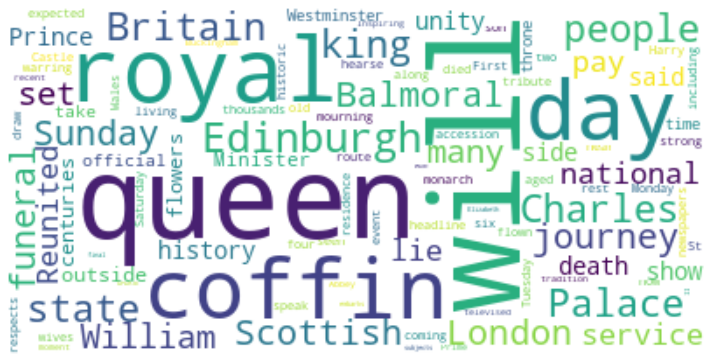

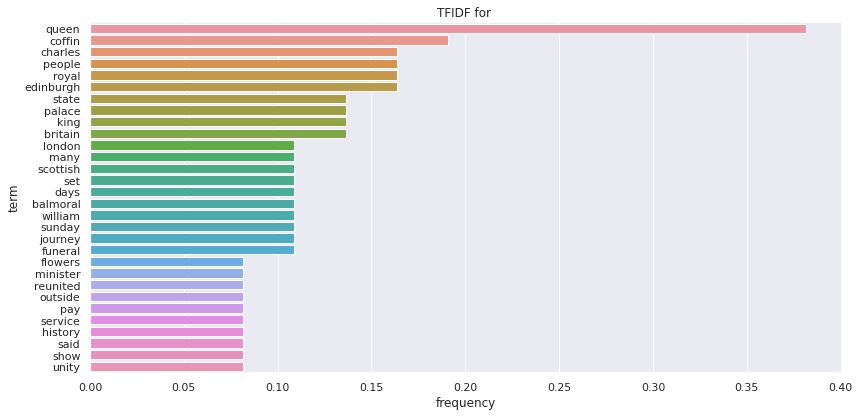

In [ ]:
visualize(ABS_rslt_df, "Text")

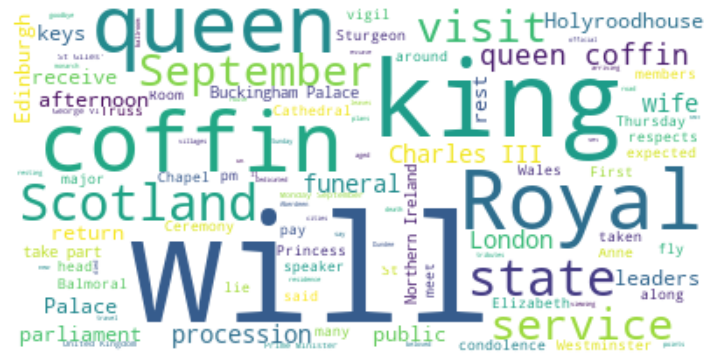

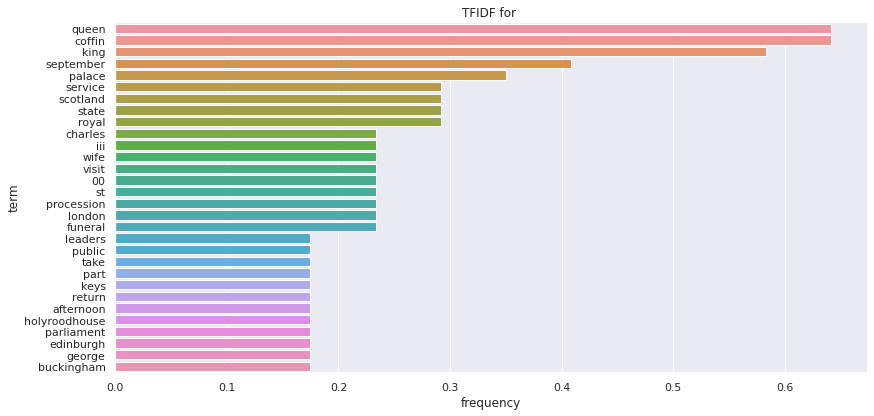

In [ ]:
visualize(GMA_rslt_df, "Text")

# Method 1: Straight Forward Way 

In [51]:
## NER extraction

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

import spacy
from spacy import displacy
from collections import Counter

from nltk.chunk import RegexpParser

from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint

In [47]:
!pip install svgling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement en_core_web_lg (from versions: none)
ERROR: No matching distribution found for en_core_web_lg


In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

In [5]:
sentence = 'European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices'


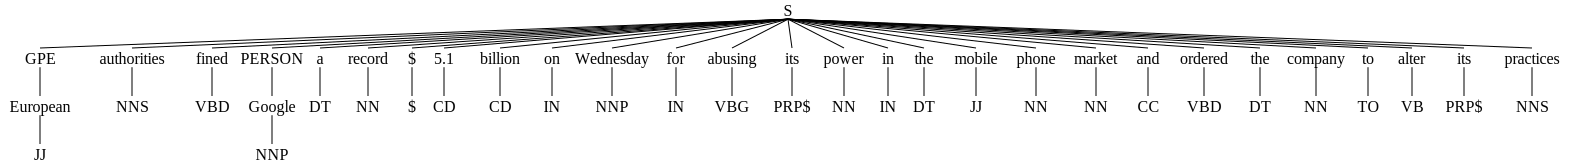

In [17]:
ne_tree = ne_chunk(pos_tag(word_tokenize(sentence)))
ne_tree

In [18]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [19]:
sent = preprocess(sentence)
sent

[('European', 'JJ'),
 ('authorities', 'NNS'),
 ('fined', 'VBD'),
 ('Google', 'NNP'),
 ('a', 'DT'),
 ('record', 'NN'),
 ('$', '$'),
 ('5.1', 'CD'),
 ('billion', 'CD'),
 ('on', 'IN'),
 ('Wednesday', 'NNP'),
 ('for', 'IN'),
 ('abusing', 'VBG'),
 ('its', 'PRP$'),
 ('power', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('mobile', 'JJ'),
 ('phone', 'NN'),
 ('market', 'NN'),
 ('and', 'CC'),
 ('ordered', 'VBD'),
 ('the', 'DT'),
 ('company', 'NN'),
 ('to', 'TO'),
 ('alter', 'VB'),
 ('its', 'PRP$'),
 ('practices', 'NNS')]

In [41]:
pattern = """ CHUNK: {<A>*<P>+} """
cp = nltk.RegexpParser(pattern)
cs = cp.parse(sent)
print(cs)

(S
  European/JJ
  authorities/NNS
  fined/VBD
  Google/NNP
  a/DT
  record/NN
  $/$
  5.1/CD
  billion/CD
  on/IN
  Wednesday/NNP
  for/IN
  abusing/VBG
  its/PRP$
  power/NN
  in/IN
  the/DT
  mobile/JJ
  phone/NN
  market/NN
  and/CC
  ordered/VBD
  the/DT
  company/NN
  to/TO
  alter/VB
  its/PRP$
  practices/NNS)


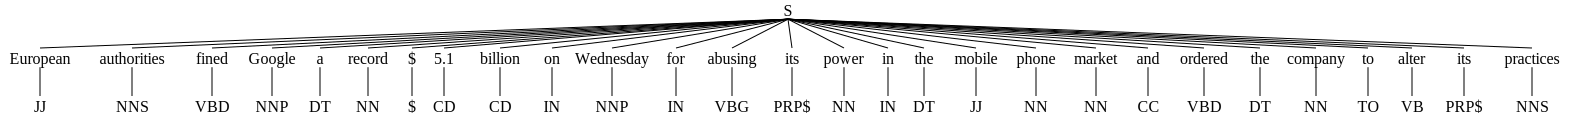

In [42]:
NPChunker = nltk.RegexpParser(pattern) 
result = NPChunker.parse(sent)
result

In [43]:
iob_tagged = tree2conlltags(cs)
pprint(iob_tagged)

[('European', 'JJ', 'O'),
 ('authorities', 'NNS', 'O'),
 ('fined', 'VBD', 'O'),
 ('Google', 'NNP', 'O'),
 ('a', 'DT', 'O'),
 ('record', 'NN', 'O'),
 ('$', '$', 'O'),
 ('5.1', 'CD', 'O'),
 ('billion', 'CD', 'O'),
 ('on', 'IN', 'O'),
 ('Wednesday', 'NNP', 'O'),
 ('for', 'IN', 'O'),
 ('abusing', 'VBG', 'O'),
 ('its', 'PRP$', 'O'),
 ('power', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('mobile', 'JJ', 'O'),
 ('phone', 'NN', 'O'),
 ('market', 'NN', 'O'),
 ('and', 'CC', 'O'),
 ('ordered', 'VBD', 'O'),
 ('the', 'DT', 'O'),
 ('company', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('alter', 'VB', 'O'),
 ('its', 'PRP$', 'O'),
 ('practices', 'NNS', 'O')]


In [48]:
# Import the SpaCy English model
try:
    nlp = spacy.load("en_core_web_lg")
except:
    nlp = spacy.load("en_core_web_sm")

In [49]:
doc = nlp(sentence)
pprint([(X.text, X.label_) for X in doc.ents])

[('European', 'NORP'),
 ('Google', 'ORG'),
 ('$5.1 billion', 'MONEY'),
 ('Wednesday', 'DATE')]


In [50]:
pprint([(X, X.ent_iob_, X.ent_type_) for X in doc])

[(European, 'B', 'NORP'),
 (authorities, 'O', ''),
 (fined, 'O', ''),
 (Google, 'B', 'ORG'),
 (a, 'O', ''),
 (record, 'O', ''),
 ($, 'B', 'MONEY'),
 (5.1, 'I', 'MONEY'),
 (billion, 'I', 'MONEY'),
 (on, 'O', ''),
 (Wednesday, 'B', 'DATE'),
 (for, 'O', ''),
 (abusing, 'O', ''),
 (its, 'O', ''),
 (power, 'O', ''),
 (in, 'O', ''),
 (the, 'O', ''),
 (mobile, 'O', ''),
 (phone, 'O', ''),
 (market, 'O', ''),
 (and, 'O', ''),
 (ordered, 'O', ''),
 (the, 'O', ''),
 (company, 'O', ''),
 (to, 'O', ''),
 (alter, 'O', ''),
 (its, 'O', ''),
 (practices, 'O', '')]
